In [1]:
import os, math, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             log_loss, roc_curve, precision_recall_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
df = pd.read_csv("Loan_Data.csv")
print(f"Loaded Loan_Data.csv with shape {df.shape}")
display(df.head())

assert "default" in df.columns, "Data must include a 'default' column (0/1)."
assert "loan_amt_outstanding" in df.columns, "Data must include 'loan_amt_outstanding' (EAD proxy)"

Loaded Loan_Data.csv with shape (10000, 8)


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


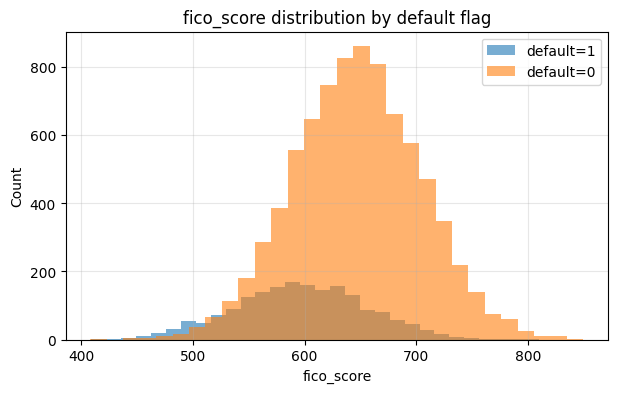

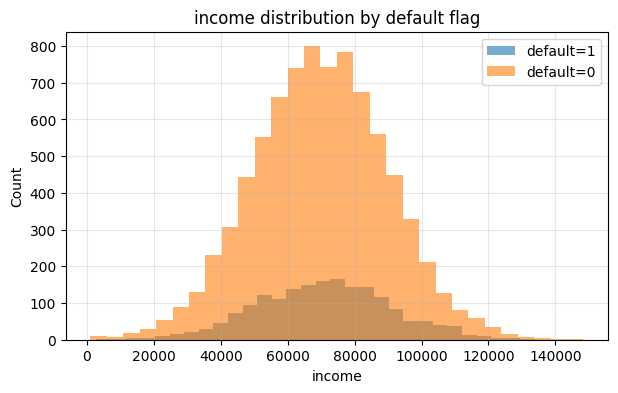

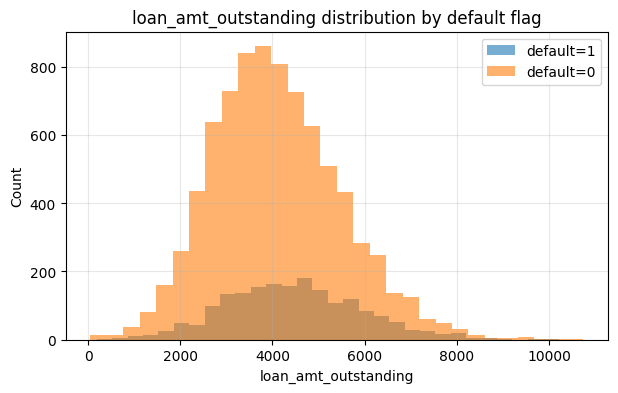

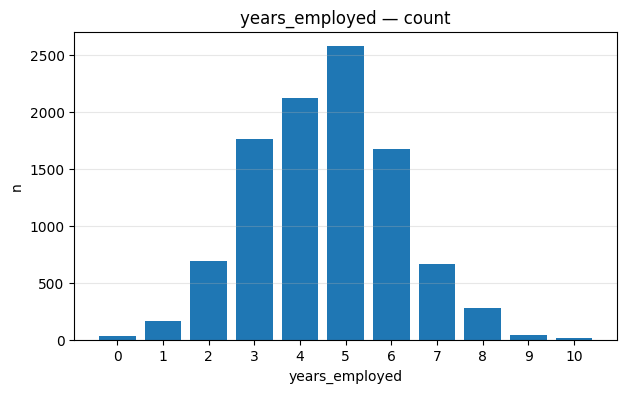

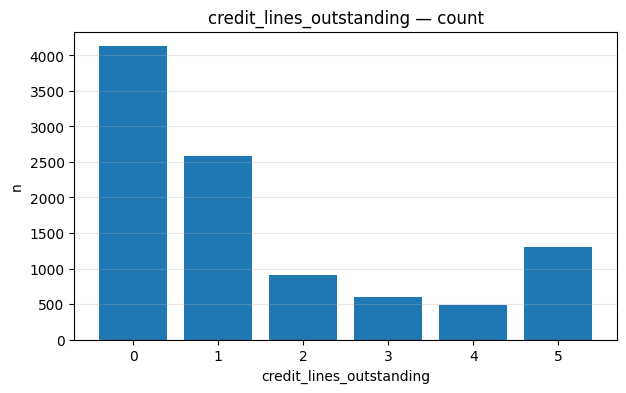

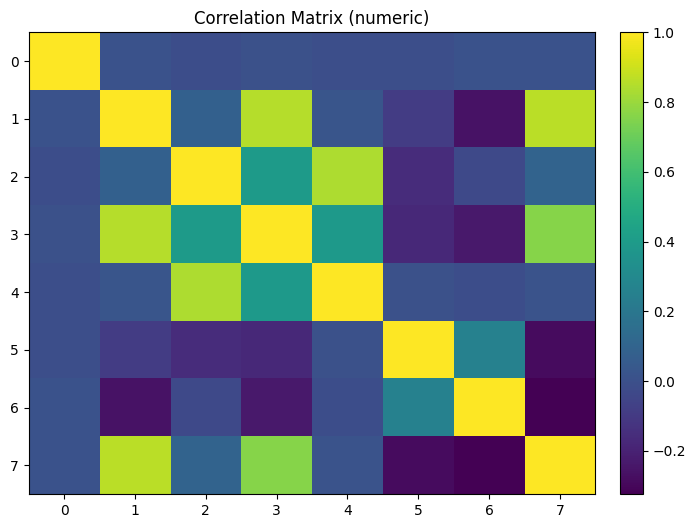

In [3]:
def dual_hist(feature, bins=30):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(df.loc[df["default"]==1, feature], bins=bins, alpha=0.6, label="default=1")
    ax.hist(df.loc[df["default"]==0, feature], bins=bins, alpha=0.6, label="default=0")
    ax.set_title(f"{feature} distribution by default flag")
    ax.set_xlabel(feature); ax.set_ylabel("Count"); ax.grid(alpha=0.3); ax.legend()
    plt.show()

for col in ["fico_score", "income", "loan_amt_outstanding"]:
    if col in df.columns:
        dual_hist(col)

# bar counts for years_employed and credit_lines_outstanding
for cat in ["years_employed", "credit_lines_outstanding"]:
    if cat in df.columns:
        counts = df[cat].value_counts().sort_index()
        fig, ax = plt.subplots(figsize=(7,4))
        ax.bar(counts.index.astype(str), counts.values)
        ax.set_title(f"{cat} — count")
        ax.set_xlabel(cat); ax.set_ylabel("n"); ax.grid(axis="y", alpha=0.3)
        plt.show()

# correlation heatmap (numeric)
fig, ax = plt.subplots(figsize=(8,6))
corr = df.select_dtypes(include=[np.number]).corr()
im = ax.imshow(corr, aspect="auto")
ax.set_title("Correlation Matrix (numeric)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

In [4]:
#Feature engineering (keep your nice ratios)
work = df.copy()

if "total_debt_outstanding" in work.columns and "income" in work.columns:
    work["ratio_income_Totdebt"] = work["income"] / work["total_debt_outstanding"].replace(0, np.nan)
if "loan_amt_outstanding" in work.columns and "income" in work.columns:
    work["ratio_income_loan_amt"] = work["income"] / work["loan_amt_outstanding"].replace(0, np.nan)

# Replace inf/NaN produced by division with medians
for c in ["ratio_income_Totdebt", "ratio_income_loan_amt"]:
    if c in work.columns:
        med = work[c].replace([np.inf, -np.inf], np.nan).median()
        work[c] = work[c].replace([np.inf, -np.inf], np.nan).fillna(med)

# Keep ID aside (not a feature)
id_col = "customer_id" if "customer_id" in work.columns else None

y = work["default"].astype(int).values
X = work.drop(columns=[c for c in ["default", id_col] if c in work.columns])

num_cols = list(X.columns)  # all numeric here
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[("imp", SimpleImputer(strategy="median")),
                               ("sc", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

In [5]:
#Split (stratified, no leakage)
print("\n🔹 Train/test split (stratified)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape}, Test: {X_test.shape} | Default rate train={y_train.mean():.3f}, test={y_test.mean():.3f}")



🔹 Train/test split (stratified)...
Train: (7500, 8), Test: (2500, 8) | Default rate train=0.185, test=0.185


In [6]:
# Candidate models with cross-validated model selection; show AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

candidates = []

# Logistic Regression (simple, explainable baseline)
logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])
logit_grid = {"clf__C": [0.1, 0.5, 1.0, 3.0, 10.0],
              "clf__class_weight": [None, "balanced"]}

candidates.append(("Logistic", logit, logit_grid))

# XGBoost (we know we have it)
xgb_pipe = Pipeline(steps=[("prep", preprocess), ("clf", xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric="logloss", tree_method="hist",n_estimators=400, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9))])

xgb_grid = {"clf__max_depth": [3, 4, 5],
            "clf__min_child_weight": [1, 5]}
candidates.append(("XGBoost", xgb_pipe, xgb_grid))

# Run grid search for each candidate
best_name, best_est, best_score = None, None, -np.inf
model_summaries = []

for name, pipe, grid in candidates:
    gs = GridSearchCV(pipe, grid, scoring="neg_log_loss", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train, y_train)
    val_score = gs.best_score_
    auc_cv = gs.cv_results_["mean_test_score"].mean()  # just for reference
    model_summaries.append((name, val_score, gs.best_params_))
    if val_score > best_score:
        best_name, best_est, best_score = name, gs.best_estimator_, val_score

print("CV results (higher neg_log_loss is better):")
for name, score, params in model_summaries:
    print(f"  • {name:8s}  neg_log_loss={score:.5f}  best_params={params}")
print(f"\n Best (by neg_log_loss): {best_name}")


CV results (higher neg_log_loss is better):
  • Logistic  neg_log_loss=-0.00781  best_params={'clf__C': 10.0, 'clf__class_weight': None}
  • XGBoost   neg_log_loss=-0.01081  best_params={'clf__max_depth': 3, 'clf__min_child_weight': 1}

 Best (by neg_log_loss): Logistic


In [ ]:
# Probability calibration on top of best model
print("\n Calibrating probabilities for EL (isotonic if enough data)...")
method = "isotonic" if len(X_train) >= 5000 else "sigmoid"
calibrated = CalibratedClassifierCV(best_est, cv=5, method=method)
calibrated.fit(X_train, y_train)


🔹 Calibrating probabilities for EL (isotonic if enough data)...


,estimator,Pipeline(step..._iter=2000))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False



Holdout performance (test set):
  ROC-AUC=1.0000 | PR-AUC=1.0000 | Brier=0.0009 | LogLoss=0.0028


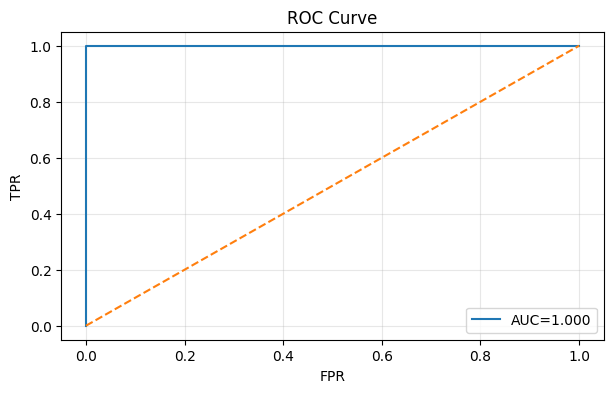

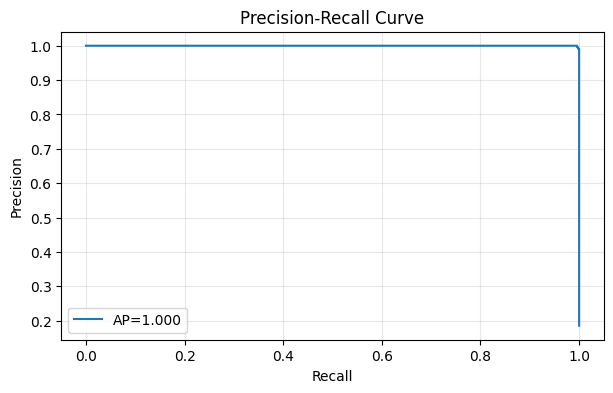

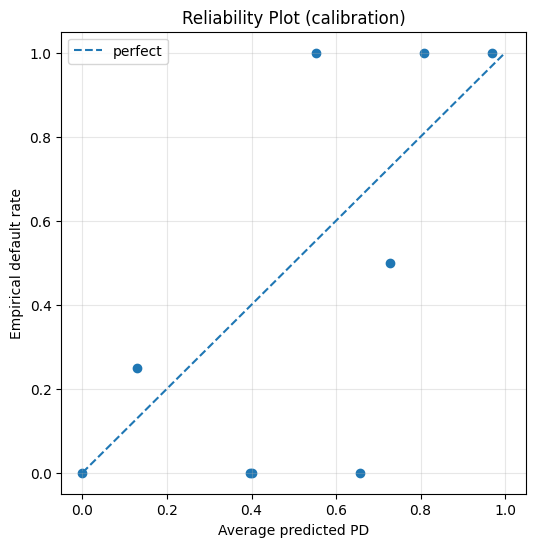

In [9]:
# Evaluate on the holdout test
print("\nHoldout performance (test set):")
pd_test = calibrated.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, pd_test)
pr_auc = average_precision_score(y_test, pd_test)
brier = brier_score_loss(y_test, pd_test)
ll = log_loss(y_test, pd_test)
print(f"  ROC-AUC={auc:.4f} | PR-AUC={pr_auc:.4f} | Brier={brier:.4f} | LogLoss={ll:.4f}")

# ROC and PR plots
def plot_roc_pr(y_true, pd_hat):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, pd_hat)
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, pd_hat):.3f}")
    ax.plot([0,1],[0,1],"--")
    ax.set_title("ROC Curve"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(alpha=0.3); ax.legend()
    plt.show()
    # PR
    prec, rec, _ = precision_recall_curve(y_true, pd_hat)
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(rec, prec, label=f"AP={average_precision_score(y_true, pd_hat):.3f}")
    ax.set_title("Precision-Recall Curve"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.grid(alpha=0.3); ax.legend(); plt.show()

plot_roc_pr(y_test, pd_test)

# Simple calibration curve visual (reliability diagram)
def reliability_plot(y_true, pd_hat, n_bins=10):
    bins = np.linspace(0,1,n_bins+1)
    idx = np.digitize(pd_hat, bins) - 1
    emp_rate, avg_pd = [], []
    for b in range(n_bins):
        mask = idx==b
        if mask.sum() == 0:
            continue
        emp_rate.append(y_true[mask].mean())
        avg_pd.append(pd_hat[mask].mean())
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot([0,1],[0,1],"--", label="perfect")
    ax.scatter(avg_pd, emp_rate)
    ax.set_title("Reliability Plot (calibration)")
    ax.set_xlabel("Average predicted PD"); ax.set_ylabel("Empirical default rate")
    ax.grid(alpha=0.3); ax.legend(); plt.show()

reliability_plot(y_test, pd_test)



Top 10 loans by Expected Loss (test set):


,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,ratio_income_Totdebt,ratio_income_loan_amt,PD,EAD,LGD,EL,customer_id
9944,4,8989.178801,30103.66256,124197.63370,2,641,4.125665,13.816349,1.0,8989.178801,0.9,8090.260921,3983392
5460,5,8841.923630,32644.92158,115203.15190,2,541,3.528976,13.029196,1.0,8841.923630,0.9,7957.731267,2527305
6364,4,8802.265206,26544.26350,108128.84130,2,534,4.073530,12.284206,1.0,8802.265206,0.9,7922.038685,2746613
346,5,8638.366979,32789.35274,111631.44970,4,627,3.404503,12.922749,1.0,8638.366979,0.9,7774.530281,1769864
7475,5,8427.592750,38215.41353,114303.69530,4,657,2.991036,13.563030,1.0,8427.592750,0.9,7584.833475,8299446
2133,5,8276.572480,43688.78410,121048.35320,2,701,2.770696,14.625421,1.0,8276.572480,0.9,7448.915232,6869178
7295,4,8133.432746,18333.75749,92937.53071,5,668,5.069203,11.426606,1.0,8133.432746,0.9,7320.089471,6982905
5201,5,8055.214307,29424.29041,103156.28370,3,578,3.505821,12.806150,1.0,8055.214307,0.9,7249.692876,6544829
7224,5,8042.192655,31775.12918,102824.67930,2,612,3.236011,12.785652,1.0,8042.192655,0.9,7237.973389,3211744
7089,5,7989.706883,33434.40397,112065.01990,1,674,3.351788,14.026174,1.0,7989.706883,0.9,7190.736195,8328500


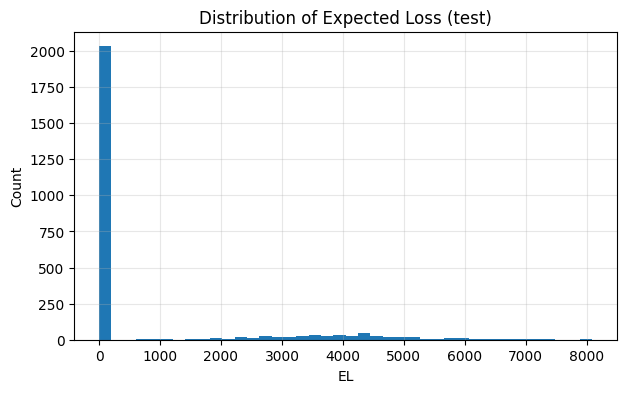

Total Expected Loss (test set) = $1,849,417


In [10]:
# Expected Loss (EL) on test set
RECOVERY = 0.10
LGD = 1.0 - RECOVERY
EAD_test = X_test["loan_amt_outstanding"].to_numpy()
EL_test = pd_test * LGD * EAD_test

test_output = X_test.copy()
test_output["PD"] = pd_test
test_output["EAD"] = EAD_test
test_output["LGD"] = LGD
test_output["EL"] = EL_test
if id_col:
    test_output[id_col] = df.loc[X_test.index, id_col].values

print("\nTop 10 loans by Expected Loss (test set):")
display(test_output.sort_values("EL", ascending=False).head(10))

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(test_output["EL"], bins=40)
ax.set_title("Distribution of Expected Loss (test)")
ax.set_xlabel("EL"); ax.set_ylabel("Count"); ax.grid(alpha=0.3)
plt.show()

print(f"Total Expected Loss (test set) = ${test_output['EL'].sum():,.0f}")

In [12]:
# Fit on FULL data for deployment 
from sklearn.base import clone

print("\nFitting calibrated model on FULL dataset (for deployment scoring)...")
# Refit best_est on ALL data, then calibrate with CV on ALL data
best_est_full = clone(best_est)   # proper cloning
best_est_full.fit(X, y)
calibrated_full = CalibratedClassifierCV(best_est_full, cv=5, method=method)
calibrated_full.fit(X, y)



Fitting calibrated model on FULL dataset (for deployment scoring)...


,estimator,Pipeline(step..._iter=2000))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [13]:
# Scoring helpers
def predict_expected_loss(input_df: pd.DataFrame,
                          model=calibrated_full,
                          ead_col: str = "loan_amt_outstanding",
                          recovery_rate: float = 0.10) -> pd.DataFrame:
    """
    Input: DataFrame with the same feature columns as training X (order doesn't matter).
    Output: original columns + PD + EL.
    """
    # rebuild the same feature engineering deterministically
    df2 = input_df.copy()
    if "income" in df2.columns and "total_debt_outstanding" in df2.columns:
        df2["ratio_income_Totdebt"] = df2["income"] / df2["total_debt_outstanding"].replace(0, np.nan)
    if "income" in df2.columns and "loan_amt_outstanding" in df2.columns:
        df2["ratio_income_loan_amt"] = df2["income"] / df2["loan_amt_outstanding"].replace(0, np.nan)
    for c in ["ratio_income_Totdebt", "ratio_income_loan_amt"]:
        if c in df2.columns:
            med = df2[c].replace([np.inf, -np.inf], np.nan).median()
            df2[c] = df2[c].replace([np.inf, -np.inf], np.nan).fillna(med)

    use_cols = [c for c in X.columns]  # same training columns, no ID/target
    missing = [c for c in use_cols if c not in df2.columns]
    if missing:
        raise ValueError(f"Missing required feature columns: {missing}")

    pd_hat = model.predict_proba(df2[use_cols])[:, 1]
    lgd = 1.0 - recovery_rate
    ead = df2[ead_col].to_numpy()
    el = pd_hat * lgd * ead

    out = df2.copy()
    out["PD"] = pd_hat
    out["LGD"] = lgd
    out["EAD"] = ead
    out["EL"] = el
    return out